In [180]:
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [181]:
# Load the data
representatives_df = pd.read_excel('Data/Representatives.xlsx')

csv_folder = os.path.join(os.getcwd(), "csv_outputs")
json_folder = os.path.join(os.getcwd(), "json_outputs")

In [182]:
print("Columns:", representatives_df.columns.tolist())

Columns: ['REP_CODE', 'REP_DESC', 'COMM_METHOD', 'COMMISSION']


In [183]:
print("Sample data:\n", representatives_df.head())

Sample data:
   REP_CODE                  REP_DESC COMM_METHOD  COMMISSION
0        0                   Unknown     Unknown         0.0
1       01               HEAD OFFICE       Sales         0.0
2      010                BA ALLISON       Sales         0.5
3     010C  BA CONSIGNMENT SALES ACC       Sales         0.5
4    01AME            01 CREDIT CARD       Sales         0.5


In [184]:
print("Null values:\n", representatives_df.isnull().sum())

Null values:
 REP_CODE       0
REP_DESC       0
COMM_METHOD    0
COMMISSION     0
dtype: int64


In [185]:
# Remove rows with any null values
representatives_df = representatives_df.dropna()

In [186]:
print("Data shape:", representatives_df.shape)

Data shape: (128, 4)


In [187]:
representatives_df

,REP_CODE,REP_DESC,COMM_METHOD,COMMISSION
0,0,Unknown,Unknown,0.0
1,01,HEAD OFFICE,Sales,0.0
2,010,BA ALLISON,Sales,0.5
3,010C,BA CONSIGNMENT SALES ACC,Sales,0.5
4,01AME,01 CREDIT CARD,Sales,0.5
...,...,...,...,...
123,ZZZ3,BAD DEBTS-DUCHESS-HANDED OVER,Gross Profit,0.0
124,ZZZ4,BAD CREDIT,Sales,0.0
125,ZZZ5,CLOSED,Sales,0.0
126,ZZZ6,BLOCK AND MOVE - DO NOT USE,Gross Profit,0.0


In [188]:
unique_values = representatives_df['REP_DESC'].unique()
unique_values

array(['Unknown', 'HEAD OFFICE', 'BA ALLISON', 'BA CONSIGNMENT SALES ACC',
       '01 CREDIT CARD', 'CAT CUSTOMER ONLY -ex BJ',
       'CAT CUSTOMER ONLY ex BM', 'CM', 'CAT CUSTOMER  ONLY- ex R',
       'CAT CUSTOMERS ONLY- ex RL', 'CH', 'Faulty code - do not use',
       'DISC.  FOR WIFES/FRIENDS', 'EM', 'EXPORTS',
       'HEAD OFFICE do not use', 'JU', 'LL Consignm', 'LL', '01 N',
       'Repairs', 'SALE HEAD OFFICE', 'SALE R', 'SALE BJ', 'SALE BM',
       'SALE RL', 'SALE DA', 'LA SALE GOODS', 'SALE CH', 'SALE JU',
       'SALE EM', "HEAD OFFICE'S CUSTOMER DEPT STORE",
       'Head Office-Top Ten Dept stores', 'VP', 'WHOLESALERS', 'R',
       'R CONSIGNMENT SALES ACC', "R'S CUSTOMER - CH'S SALE", 'DR',
       'do not use', "R'S CUSTOMER - JU'S SALE", "R'S CUTOMER -EM'S SALE",
       'R  discount customer', "R's customer - RO's sale", 'BJ',
       'BJ discount customer', 'BJ CONSIGNMENTS',
       "BJ'S CUSTOMER - CH'S SALE", "BJ'S CUSTOMER - JU'S SALE",
       "BJ'S CUSTOMER- EM'S SA

In [189]:

# Strip whitespace and list unique REP_DESC values
unique_rep_desc = representatives_df['REP_DESC'].astype(str).str.strip().unique()

# Display as a sorted DataFrame for inspection
pd.DataFrame({'REP_DESC': sorted(unique_rep_desc)})

,REP_DESC
0,01 CREDIT CARD
1,01 N
2,07-GROUP-LA
3,BA ALLISON
4,BA CONSIGNMENT SALES ACC
...,...
114,VP
115,WHOLESALERS
116,discount specials
117,do not use


### Cleaning and Validating Representative Descriptions (`REP_DESC`)

This step standardizes and renames ambiguous or system-generated descriptions. We also validate which entries belong in the `dim_representative` table.

- **Valid entries** include real agents and recognized sales channels (e.g., consignment, catalogue).
- **Excluded entries** include placeholders, internal routing, discounts, and financial exceptions.

This ensures that only meaningful, joinable entities are retained in the dimension table.

In [190]:

# Create a comprehensive mapping dictionar
rep_desc_map = {
    # 1. Sales Reps (Use initials to categorize specific customers/sales)
    'R': 'R',
    'R CONSIGNMENT SALES ACC': 'R',
    "R'S CUSTOMER - CH'S SALE": 'R',
    "R'S CUSTOMER - JU'S SALE": 'R',
    "R'S CUTOMER -EM'S SALE": 'R',
    "R's customer - RO's sale": 'R',
    'R  discount customer': 'R',

    'BJ': 'BJ',
    'BJ discount customer': 'BJ',
    'BJ CONSIGNMENTS': 'BJ',
    "BJ'S CUSTOMER - CH'S SALE": 'BJ',
    "BJ'S CUSTOMER - JU'S SALE": 'BJ',
    "BJ'S CUSTOMER- EM'S SALE": 'BJ',
    "BJ'S CUSTOMER- PROBLEM ACC": 'BJ',
    'BJ Exhibition': 'BJ',

    'BM': 'BM',
    'BM CONSIGNMENT SALES ACC': 'BM',
    "BM'S CUSTOMER - CH'S SAL": 'BM',
    "BM'S CUSTOMER - JU'S SALE": 'BM',
    "BM'S CUSTOMER-EM'S SALE": 'BM',
    'BM discount customer': 'BM',
    'BM FREE STATE + LESOTHO': 'BM', # Treat as a geographical extension of the rep's sales

    'RL': 'RL',
    'RL CONSIGNMENT SALES ACC': 'RL',
    "RL'S CUSTOMER - CH SALE": 'RL',
    "RL'S CUSTOMER - JU'S SALE": 'RL',

    'DA': 'DA',
    'DA CONSIGNMENT': 'DA',
    "DA CUSTOMER VP'S SAL": 'DA',
    "DA's Customer - EM's sal": 'DA',
    "DA CUSTOMER JU'S SALE": 'DA',
    'DA discount customer': 'DA',

    'LA': 'LA',
    'LA Consignments SalesAcc': 'LA',
    "LA CUST-VP'S SALE": 'LA',
    'LA CUST-EM SALE': 'LA',
    'LA CUSTJU SALE': 'LA',
    'LA Discount Customers': 'LA',
    '07-GROUP-LA': 'LA',

    'BA ALLISON': 'BA',
    'BA CONSIGNMENT SALES ACC': 'BA',
    'CONSIGNMENT BA': 'BA_CONSIGNMENT', # Keep CONSIGNMENT separate
    'CH': 'CH',
    'JU': 'JU',
    'EM': 'EM',
    'VP': 'VP',
    'ML': 'ML',
    'SH': 'SH',
    'GR': 'GR',
    'DR': 'DR',

    # 2. Head Office
    'HEAD OFFICE': 'HEAD OFFICE',
    "HEAD OFFICE'S CUSTOMER DEPT STORE": 'HEAD OFFICE',
    'Head Office-Top Ten Dept stores': 'HEAD OFFICE',
    'HO discount customer': 'HEAD OFFICE',
    "HO'S CUSTOMER-EM'S SALE": 'HEAD OFFICE',

    # 3. Consignment
    'LL Consignm': 'CONSIGNMENT',
    'LL': 'CONSIGNMENT',
    'CONSIGNMENT DE/STAND': 'CONSIGNMENT',
    'CONSIGNMENT BJ/STAND': 'CONSIGNMENT',
    'CONSIGNMENT BM/STAND': 'CONSIGNMENT',
    'CONSIGNMENT HO/STAND': 'CONSIGNMENT',
    'CONSIGNMENT DA/STAND': 'CONSIGNMENT',
    'Consignment LA / Stand': 'CONSIGNMENT',
    'CONSIGNMENTS HEAD OFFICE': 'CONSIGNMENT',
    'CONSIGNMENTS DE': 'CONSIGNMENT',
    'CONSIGNMENTS BJ': 'CONSIGNMENT',
    'CONSIGNMENTS BM': 'CONSIGNMENT',
    'CONSIGNMENTS HO': 'CONSIGNMENT',
    'CONSIGNMENTS DA': 'CONSIGNMENT',
    'Consignments LA': 'CONSIGNMENT',
    'STANDS- 30 PC CONSIGNMENT': 'CONSIGNMENT_STANDS',
    'STANDS-CONSIGNMENT': 'CONSIGNMENT_STANDS',
    'STAND-60PC CONSIGNMENT': 'CONSIGNMENT_STANDS',
    'HOUSE CONSIGNMENTS': 'CONSIGNMENT',

    # 4. Catalogue/Digital
    'CAT CUSTOMER ONLY -ex BJ': 'CATALOGUE',
    'CAT CUSTOMER ONLY ex BM': 'CATALOGUE',
    'CAT CUSTOMER  ONLY- ex R': 'CATALOGUE',
    'CAT CUSTOMERS ONLY- ex RL': 'CATALOGUE',
    'CATALOGUE CUSTOMER ONLY - BJ': 'CATALOGUE',
    'CATALOGUE CUSTOMER ONLY - BM': 'CATALOGUE',
    'CATALOGUE CUSTOMER ONLY - RO': 'CATALOGUE',
    'CATALOGUE CUSTOMER-CH': 'CATALOGUE',
    'CM': 'CATALOGUE', # CM likely stands for Catalogue Mail

    # 5. Wholesaler/Export
    'WHOLESALERS': 'WHOLESALERS',
    'EXPORTS': 'EXPORTS',

    # 6. Problem/Do Not Use (Flagging as UNWANTED_DATA for easy filtering later)
    'Faulty code - do not use': 'UNWANTED_DATA',
    'HEAD OFFICE do not use': 'UNWANTED_DATA',
    'do not use': 'UNWANTED_DATA',
    'BLOCK AND MOVE - DO NOT USE': 'UNWANTED_DATA',
    'PROBLEM - DECEASED ESTATES': 'PROBLEM_ACCOUNT',
    'PROBLEM - INSOLVENT ACCOUNT': 'PROBLEM_ACCOUNT',
    'PROBLEM-BAD DEBT-PAYING OFF': 'PROBLEM_ACCOUNT',
    'BAD DEBT- H/OVER': 'BAD_DEBT',
    'BAD DEBTS-DUCHESS-HANDED OVER': 'BAD_DEBT',
    'BAD CREDIT': 'BAD_DEBT',
    'CLOSED': 'CLOSED_ACCOUNT',

    # 7. Special Sale/Discount/Other Transaction Type
    'SALE HEAD OFFICE': 'SALE',
    'SALE R': 'SALE',
    'SALE BJ': 'SALE',
    'SALE BM': 'SALE',
    'SALE RL': 'SALE',
    'SALE DA': 'SALE',
    'LA SALE GOODS': 'SALE',
    'SALE CH': 'SALE',
    'SALE JU': 'SALE',
    'SALE EM': 'SALE',
    'DISC. FOR WIFES/FRIENDS': 'DISCOUNT',
    'discount specials': 'DISCOUNT',
    'PROMOTION ONCE-OFF': 'PROMOTION',
    'Repairs': 'REPAIRS',
    'REPAIR': 'REPAIRS',
    'sales stock': 'STOCK_MOVEMENT',
    'SAMPLES': 'SAMPLES',
    'STOCK MOVEMENT / SHIPMENTS/': 'STOCK_MOVEMENT',

    # 8. Unknown/Other
    'Unknown': 'UNKNOWN',
    '01 CREDIT CARD': 'UNKNOWN',
    '01 N': 'UNKNOWN',
    'C- ITC': 'UNKNOWN',
    'C LEGAL': 'UNKNOWN',
}

In [191]:
# Apply mapping
representatives_df['REP_DESC_CLEAN'] = representatives_df['REP_DESC'].map(rep_desc_map)

# Define values to drop
drop_rep_clean_values = [
    'UNWANTED_DATA',        # Mapped 'do not use', 'Faulty code - do not use', etc.
    'PROBLEM_ACCOUNT',      # Mapped 'PROBLEM - DECEASED ESTATES', etc.
    'BAD_DEBT',             # Mapped 'BAD DEBT- H/OVER', 'BAD CREDIT', etc.
    'CLOSED_ACCOUNT',       # Mapped 'CLOSED'
    'STOCK_MOVEMENT',       # Mapped 'sales stock', 'STOCK MOVEMENT / SHIPMENTS/'
    'REPAIRS',              # Mapped 'Repairs', 'REPAIR'
    'SAMPLES',              # Mapped 'SAMPLES'
    'PROMOTION',            # Mapped 'PROMOTION ONCE-OFF'
    'DISCOUNT',             # Mapped 'DISC. FOR WIFES/FRIENDS', 'discount specials'
    'UNKNOWN'               # Mapped 'Unknown', '01 CREDIT CARD', 'C LEGAL', etc.
]

# Drop rows with invalid REP_DESC
representatives_df_filtered = representatives_df.loc[
    ~representatives_df['REP_DESC_CLEAN'].isin(drop_rep_clean_values)
].copy()

def classify_rep_group(rep_clean):
    if pd.isna(rep_clean) or not isinstance(rep_clean, str):
        return 'Unclassified_Missing_Data'
    
    if len(rep_clean) <= 2:
        # Assumes single/double letters are specific sales representatives (R, BJ, BM, DA, etc.)
        return 'Sales Rep'
    elif rep_clean == 'HEAD OFFICE':
        return 'Internal Sales'
    elif 'CONSIGNMENT' in rep_clean:
        return 'Channel: Consignment'
    elif rep_clean == 'CATALOGUE':
        return 'Channel: Catalogue'
    elif rep_clean == 'WHOLESALERS':
        return 'Channel: Wholesaler'
    elif rep_clean == 'EXPORTS':
        return 'Channel: Export'
    else:
        # This acts as a final check for any unexpected clean values.
        return 'Unclassified'

representatives_df_filtered.loc[:, 'REP_GROUP'] = representatives_df_filtered['REP_DESC_CLEAN'].apply(classify_rep_group)

# Inspect cleaned REP_DESC
inspection_df = representatives_df_filtered[[
    'REP_CODE', 'REP_DESC', 'REP_DESC_CLEAN', 'REP_GROUP'
]].drop_duplicates().sort_values('REP_DESC').reset_index(drop=True)

In [192]:
representatives_df_filtered.to_csv(os.path.join(csv_folder, "representatives_clean.csv"), index=False)
representatives_df_filtered.to_json(os.path.join(json_folder, "representatives_clean.json"), orient="records", lines=True)

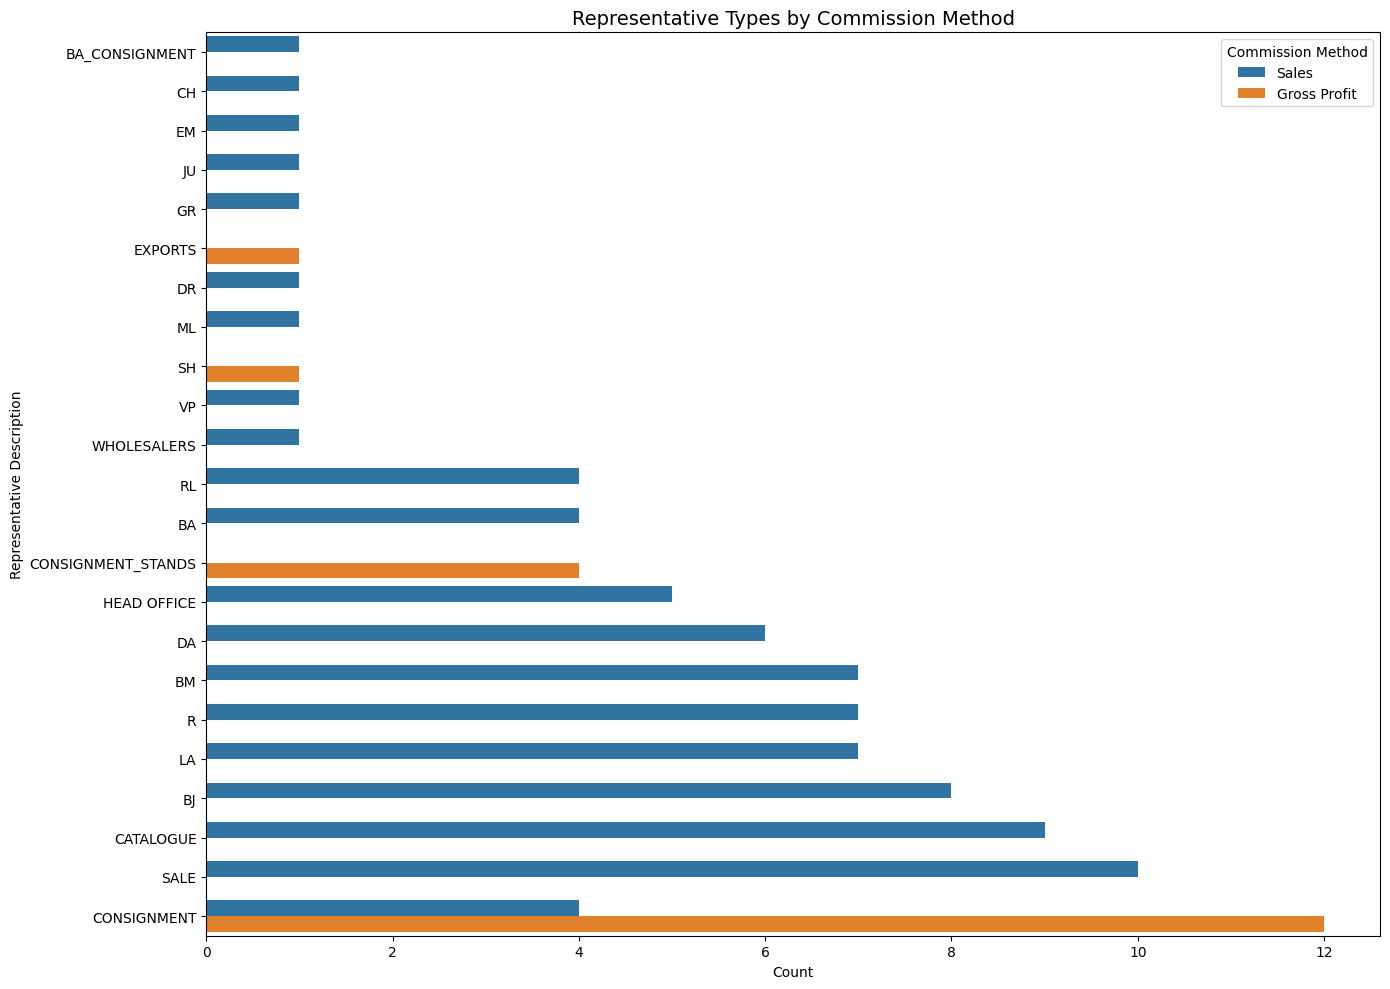

In [193]:
# Count reps per COMM_METHOD
rep_method_counts = representatives_df_filtered.groupby(['REP_DESC_CLEAN', 'COMM_METHOD']).size().reset_index(name='Count')

# Sort by total count for better layout
rep_order = rep_method_counts.groupby('REP_DESC_CLEAN')['Count'].sum().sort_values().index

# Plot horizontally
plt.figure(figsize=(14, 10))
sns.barplot(
    data=rep_method_counts,
    y='REP_DESC_CLEAN',
    x='Count',
    hue='COMM_METHOD',
    order=rep_order
)
plt.title('Representative Types by Commission Method', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Representative Description')
plt.legend(title='Commission Method', loc='upper right')
plt.tight_layout()
plt.show()


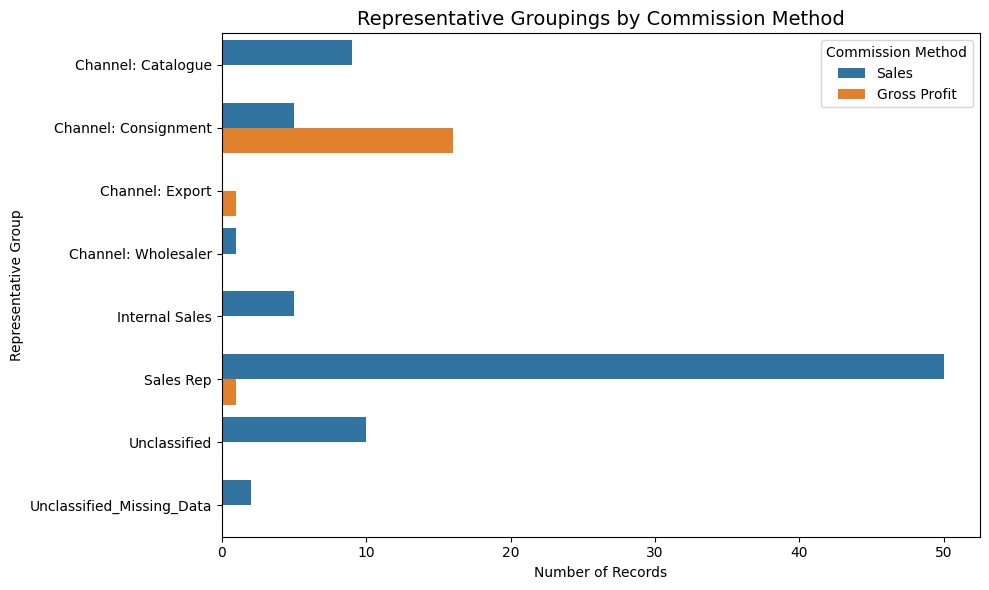

In [194]:
# Count by group and commission method
group_counts = representatives_df_filtered.groupby(['REP_GROUP', 'COMM_METHOD']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=group_counts, x='Count', y='REP_GROUP', hue='COMM_METHOD')
plt.title('Representative Groupings by Commission Method', fontsize=14)
plt.xlabel('Number of Records')
plt.ylabel('Representative Group')
plt.legend(title='Commission Method', loc='upper right')
plt.tight_layout()
plt.show()

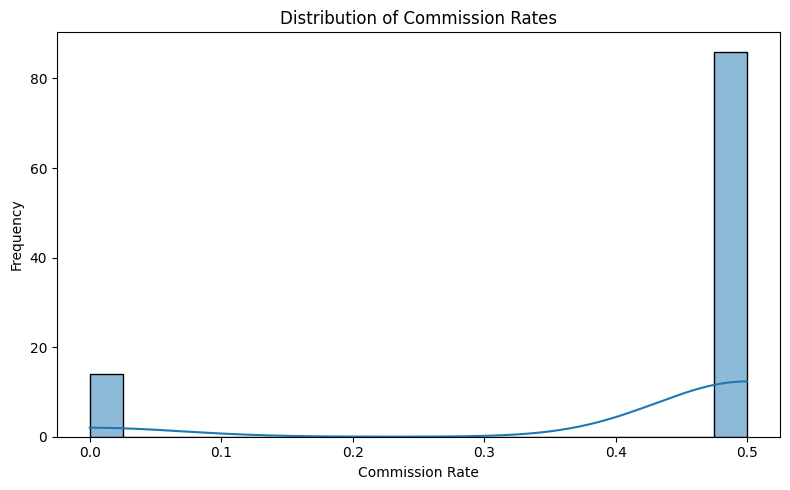

In [195]:
# Standardize COMMISSION column
representatives_df_filtered['COMMISSION'] = pd.to_numeric(representatives_df_filtered['COMMISSION'], errors='coerce')

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(representatives_df_filtered['COMMISSION'], bins=20, kde=True)
plt.title('Distribution of Commission Rates')
plt.xlabel('Commission Rate')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

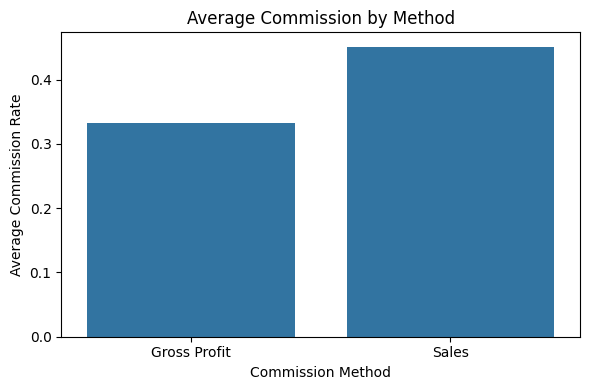

In [196]:
avg_comm_by_method = representatives_df_filtered.groupby('COMM_METHOD')['COMMISSION'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_comm_by_method, x='COMM_METHOD', y='COMMISSION')
plt.title('Average Commission by Method')
plt.ylabel('Average Commission Rate')
plt.xlabel('Commission Method')
plt.tight_layout()
plt.show()

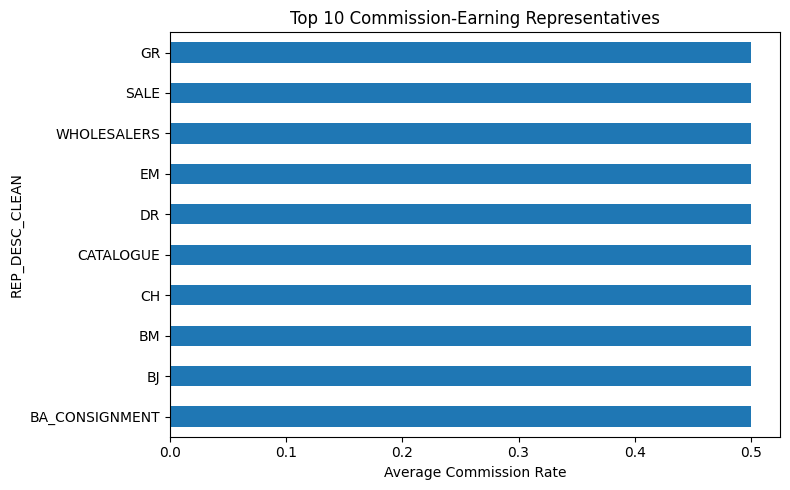

In [197]:
top_comm_reps = representatives_df_filtered.groupby('REP_DESC_CLEAN')['COMMISSION'].mean().sort_values(ascending=False).head(10)

# Plot
top_comm_reps.plot(kind='barh', figsize=(8, 5), title='Top 10 Commission-Earning Representatives')
plt.xlabel('Average Commission Rate')
plt.tight_layout()
plt.show()